# 0. Введение

В этом ноутбуке мы будем решать задачу OCR (Optical Character Recognition).

Решая эту задачу, мы предполагаем, что ранее мы уже решили задачу детекции текста, и теперь видимый текст разбит на полоски, в каждой из которых содержится только одна строка.

Таким образом, мы должны решить следующую задачу: на входе -- полоска с изображением строки текста, а на выходе -- соответствующая последовательность символов.

Для создания такой модели, нам необходимо сделать следующее (как и в любой другой задаче машинного обучения):
1. Собрать датасет для обучения
2. Собрать архитектуру, которую будем обучать
3. Сделать функцию потерь для обучения
4. *Сделать метрики для обучения
5. Запустить обучение

Этого плана и будем придерживаться. 

Следующие несколько ячеек будут общими для всех последующих ноутбуков.

* Эта ячейка настраивает отображение ipython widgets

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

* Подключаем Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

* Указываем путь к папке с кодом: 

In [ ]:
repo_folder = '/content/drive/MyDrive/github/'

* Устанавливаем зависимости

In [ ]:
reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt '
!pip3 install -r {reqs_path}

* Подключаем WandB

In [ ]:
import wandb
wandb_key = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
wandb.login(key=wandb_key)

* Подключаем утилиты для этого ноутбука

In [ ]:
import sys
base_folder = repo_folder + 'IntelligentDocumentProcessing/Resources/b_Optical_Character_Recognition/'
sys.path.append(base_folder)

## Фиксируем генераторы случайных чисел 

In [ ]:
from utils import set_seed

set_seed(17)

# 1. Данные

Для начала необходимо загрузить данные из статей Википедии (находятся в папке `resources/wiki/`), слегка их очистить и преобразовать в строки. 

Как было сказано в лекции, существует большая проблема, связанная с размеченными русскоязычными данными (наверняка такая же проблема существует и для ряда менее популярных языков). Поэтому синтез данных -- наш выбор!

Мы будем синтезировать тексты на основе википедии. У этого источника есть много плюсов, но также есть и минусы: 
- **+++** Популярный источник, который много где используется по умолчанию, а значит он протестирован и показывает себя неплохо;
- **+++** Большое разнообразие терминологии и языка в целом;
- **+++** Много пунктуации и чисел;
- **---** Много лишних символов, которые надо чистить; 
- **---** Если сэмплировать из недостаточно случайной выборки, то данные будут однообразные. 

Но для нашей задачи, разбора юридических документов, такой источник текстов пойдет.

Синтез данных будем делать по следующему плану:

1. Загрузка текстов из базы
2. Рендеринг текстов
3. Наложение искажений на изображение (Аугментации)

## 1.1. Загрузим тексты из базы

Здесь задача инженерная: в папке `Resources/b_Optical_Character_Recognition/resources/wiki` лежит по 5 файлов для английского и для русского языков. Эти файлы нужно считать, разбить на предложения по точкам -- это и будет набор наших предложений, из которых мы будем затем генерировать синтетику.

Однако еще одной проблемой стоит озаботиться: мы рассчитываем на достаточно ограниченный набор символов. Поэтому нужно избавиться от тех символов, которые отличаются от заданного набора.

Первую часть задачи решит функция `make_sentences_from_wiki(path, alphabet, max_length)`

Внутри эта функция будет использовать `filter_alphabet_and_length(text, alphabet, max_length)` 

In [ ]:
from utils import make_sentences_from_wiki

punct = " !\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~«»№"
digit = "0123456789"
cr = "ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё"
latin = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'

ru_alphabet = punct+digit+cr
en_alphabet = punct+digit+latin

ru_path = base_folder+'resources/wiki/ru'
all_ru_sentences = make_sentences_from_wiki(ru_path, ru_alphabet, 50)
en_path = base_folder+'resources/wiki/en'
all_en_sentences = make_sentences_from_wiki(en_path, en_alphabet, 50)

Когда данные загружены, как всегда, нужно проверить, что же загрузилось. Очень часто проблемы, которые потом долго искать, могут быть решены прямо на ходу на стадии создания кода.

In [ ]:
print(len(all_ru_sentences), len(all_en_sentences))
print(all_ru_sentences[1000])
print(all_en_sentences[1000])

## 1.2. Рендеринг текстов

Теперь, когда тексты загружены, мы можем генерировать данные. Для этого нам сначала понадобятся шрифты, они находятся в директории  `resources/fonts`.

In [ ]:
from pathlib import Path

FONTS = [str(font) for font in Path(base_folder+'resources/fonts/').glob('*.ttf')]

len(FONTS), FONTS

И, наконец, можно сгенерировать какое-нибудь изображение вместе с разметкой. Для этого выберем случайные предложения (по 3 штуки на английском и на русском). 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from trdg.generators import GeneratorFromStrings


sample_words = list(np.random.choice(all_en_sentences, 3)) + list(np.random.choice(all_ru_sentences, 3))

generator = GeneratorFromStrings(
    sample_words,
    count=len(sample_words),
    fonts=FONTS
)

for image, label in generator:
    plt.imshow(image)
    plt.title(label)
    plt.show()

### Задача 1. Функция для генерации датасета

Вам необходимо реализовать функцию `generate_dataset`, которая генерирует синтетический датасет по заданным параметрам: 
- `all_texts` - список строк, из которых будет генерироваться целевое подмножество
- `count` - целое число, длина целевого датасета
- `result_images_path` - папка, в которую будут сохранены изображения
- `result_ann_path` - путь, по которому будет сохранен файл с разметкой

Разметка датасета должна быть в формате CSV с такими столбцами: 

| filename | text        |
| ---------| ----------- |
| 0.png    | text0       |
| 1.png    | text1       |
| 2.png    | text2       |

После того, как функция будет написана, необходимо сгенерировать 4 датасета: train/val датасеты для русского языка (размерами 15000 и 3000) и аналогично train/val для английского языка (размерами 5000 и 1000). Полностью генерация всех четырех папок может занять от 5 до 10 минут. 

```
data
└───ru_synth
│   │   train.csv
│   │   val.csv
│   │
│   └───train
│   │   │   image1.png
│   │   │   image2.png
│   │ 
│   └───val
│       │   image1.png
│       │   image2.png
└───en_synth
    │   train.csv
    │   val.csv
    │
    └───train
    │   │   image1.png
    │   │   image2.png
    │ 
    └───val
        │   image1.png
        │   image2.png
```

In [ ]:
# КОД ДЛЯ СТУДЕНТА
from typing import List

def generate_dataset(
    all_texts: List[str], 
    count: int, 
    result_images_path: str, 
    result_ann_path: str
) -> None:
    pass

In [ ]:
# КОД ДЛЯ СТУДЕНТА
ru_folder = 'data/ru_synth/'
en_folder = 'data/en_synth/'

generate_dataset(..., 15000, ru_folder + 'train', ru_folder + 'train.csv')
generate_dataset(..., 3000, ru_folder + 'val', ru_folder + 'val.csv')
generate_dataset(..., 5000, en_folder + 'train', en_folder + 'train.csv')
generate_dataset(..., 1000, en_folder + 'val', en_folder + 'val.csv')

In [ ]:
# лайфхак: можно генерировать все датасеты одновременно с помощью мультипроцессинга: 
# from multiprocessing import Pool

# starmap_params = [
#     (..., 15000, ru_folder + 'train', ru_folder + 'train.csv'),
#     (..., 3000, ru_folder + 'val', ru_folder + 'val.csv'),
#     (..., 5000, en_folder + 'train', en_folder + 'train.csv'),
#     (..., 1000, en_folder + 'val', en_folder + 'val.csv'),
# ]
# pool = Pool(4)
# pool.starmap(generate_dataset, starmap_params)

#### Проверка

In [ ]:
import shutil

# проверка функции generate_dataset
tmp_folder = 'data/tmp/'
images_folder = tmp_folder + 'test'
ann_path = tmp_folder + 'test.csv'
dataset_len = 50
os.makedirs(images_folder, exist_ok=True)
generate_dataset(all_ru_sentences, dataset_len, images_folder, ann_path)
assert len(os.listdir(images_folder)) == dataset_len, f'Количество изображений в целевой папке {images_folder} не равно {dataset_len}.'
assert os.path.exists(ann_path), f'Разметка не найдена по заданному пути: {ann_path}'
data = pd.read_csv(ann_path)
assert len(data) == dataset_len, f'Количество строк в файле разметке {ann_path} не равно количеству файлов.'
shutil.rmtree(tmp_folder)

In [ ]:
# проверка сгенерированных датасетов 
dataset_lengths = [15000, 3000, 5000, 1000]
images_folders = [ru_folder + 'train', ru_folder + 'val', en_folder + 'train', en_folder + 'val']
ann_paths = [ru_folder + 'train.csv', ru_folder + 'val.csv', en_folder + 'train.csv', en_folder + 'val.csv']
for dataset_len, images_folder, ann_path in zip(dataset_lengths, images_folders, ann_paths):
  assert len(os.listdir(images_folder)) == dataset_len, f'Количество изображений в целевой папке {images_folder} не равно {dataset_len}.'
  assert os.path.exists(ann_path), f'Разметка не найдена по заданному пути: {ann_path}'
  data = pd.read_csv(ann_path)
  assert len(data) == dataset_len, f'Количество строк в файле разметке {ann_path} не равно количеству файлов.'

Готово! Мы сгенерировали данные с разметкой для задачи OCR. Эти данные выглядят как прямоугольные кусочки с текстом. Однако они пока что очень однообразны. Для того, чтобы сделать алгоритм устойчивым к искажениям, нужно генерировать изображения с искажениями.

## 1.3. Аугментации

В реальной жизни различными могут быть не только шрифты, но и: цвет, фон, оптические артефакты при фотографировании или сканировании, может быть раличная текстура бумаги.

Поэтому, для того, чтобы алгоритм, который мы обучим, получился устойчивым, необходимо при обучении модели демонстрировать максимально разнообразно искаженные изображения.

Для того, чтобы тестировать искажения, которые мы будем применять к изображениям, возьмем пример одного изображения для начала.


In [ ]:
import cv2

# исходная картинка
image = cv2.imread(base_folder+'images/example.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

Для того, чтобы делать аугментации, имеется специальные библиотеки в Python. Вот две наиболее популярные из них:

* albumentations
* imgaug

Как правило, их функционала достаточно для того, чтобы делать очень разнообразные визуальные искажения данных.

В нашей работе будем использовать albumentations.

### 1.3.1 Стандартные аугментации

Посмотрим, что можно сделать на основе того, что уже есть в библиотеке со стандартными аугментациями.

Что мы будем делать ниже:
* поворот, смещение и масштабирование (`ShiftScaleRotate`)
* изменение насыщенности, оттенка и цвета (`HueSaturationValue`)
* размытие (`GaussianBlur`)
* компрессия в JPEG (`ImageCompression`)
* изменение яркости и контраста (`RandomBrightnessContrast`)
* сепия (`ToSepia`)

Каждую аугментацию можно предварительно посмотреть в [демо от albumentations](https://albumentations-demo.herokuapp.com/). 

In [ ]:
import albumentations as A

# визуализация различных аугментаций
augmentations = [
    A.ShiftScaleRotate(shift_limit=0.03, rotate_limit=2, interpolation=1, border_mode=1, p=0.3),
    A.HueSaturationValue(hue_shift_limit=50, sat_shift_limit=50, val_shift_limit=50, p=0.5),
    A.GaussianBlur(blur_limit=(3, 3), p=0.1),
    A.ImageCompression(quality_lower=10, quality_upper=50, p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.3, brightness_by_max=False, p=0.1),
    A.ToSepia(p=0.15)
]
    
fig = plt.figure(figsize=(16, 5))
columns = np.ceil(len(augmentations) / 2).astype(int)
rows = 2
for i, aug in enumerate(augmentations):
    image_aug = aug(image=image, force_apply=True)['image']
    fig.add_subplot(rows, columns, i+1)
    plt.title(aug.__class__.__name__)
    plt.imshow(image_aug)
plt.show()

### 1.3.2. Кастомные аугментации

Может так оказаться, что какой-то аугментации не хватает. В нашем случае не хватает шума `SaltAndPepper`.

Что это за шум? На печатных документах и сканах мы часто видим много шума в виде белых или черных точек, вот пример:

<div>
<img src='https://i.imgur.com/jx8MPc9.png' width=500>
</div>

Реализуем эту аугментацию самостоятельно.

#### Задача

Необходимо реализовать 3 метода:
- `_salt`: при заданном amount (0 <= amount <= 1) превращает каждый пиксель в 255 с указанной вероятностью amount;
- `_pepper`: при заданном amount (0 <= amount <= 1) превращает каждый пиксель в 0 с указанной вероятностью amount;
- `apply`: вычисляет salt_amount (0 <= salt_amount <=  max_salt_amount), затем применяет `_salt`; затем аналогично с методом `_pepper`.

#### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
from albumentations.core.transforms_interface import ImageOnlyTransform
from typing import Optional

class SaltAndPepper(ImageOnlyTransform):
    def __init__(self, p: float, max_salt_amount: float = 0.1, max_pepper_amount: float = 0.1):
        """
        Кастомная аугментация с добавлением белого (соль) и черного (перец) шума на изображение.

        Args:
            p: вероятность использовать аугментации
            max_salt_amount: максимальная доля пикселей, которые станут белыми
            max_pepper_amount: максимальная доля пикселей, которые станут черными
        """
        super().__init__(p=p)
        assert 0 <= max_salt_amount <= 1
        self.max_salt_amount = max_salt_amount
        assert 0 <= max_pepper_amount <= 1
        self.max_pepper_amount = max_pepper_amount

    def apply(self, image: np.ndarray, **params) -> np.ndarray:
        """
        Основной метод, который преобразовывает изображение. 

        Args:
            image: исходное изображение
            **params:

        Returns:
            преобразованное изображение
        """
        pass

    @staticmethod
    def _salt(image: np.ndarray, amount: float) -> np.ndarray:
        """
        Вспомогательный метод для изменения некоторых пикселей на белые. 
        
        Args:
            image: исходное изображение
            amount: доля пикселей, которые станут белыми

        Returns:
            преобразованное изображение
        """
        pass

    @staticmethod
    def _pepper(image: np.ndarray, amount: float) -> np.ndarray:
        """
        Вспомогательный метод для изменения некоторых пикселей на черные. 

        Args:
            image: исходное изображение
            amount: доля пикселей, которые станут черными

        Returns:
            преобразованное изображение
        """
        pass

#### Проверка решения

In [ ]:
test_image = np.full((100, 100, 3), 128, dtype=np.uint8)
sandp = SaltAndPepper(
    p=1.0, 
    max_salt_amount=0.05, 
    max_pepper_amount=0.08,
)
tol = 0.01

salt_amount = 0.1
salted = sandp._salt(image=test_image, amount=salt_amount)
salt_amount_on_image = len(salted[salted == 255]) / len(salted.reshape(-1))
assert salt_amount_on_image > 0, 'На изображении нет "соли".'
assert abs(salt_amount - salt_amount_on_image) <= tol, 'Количество "соли" на изображении сильно отличается от 0.1.'

pepper_amount = 0.1
peppered = sandp._pepper(image=test_image, amount=pepper_amount)
pepper_amount_on_image = len(peppered[peppered == 0]) / len(peppered.reshape(-1))
assert pepper_amount_on_image > 0, 'На изображении нет "перца".'
assert abs(pepper_amount - pepper_amount_on_image) <= tol, 'Количество "перца" на изображении сильно отличается от 0.1.'

Также давайте кроме численных проверок посмотрим на то, как выглядят картинки с "солью", с "перцем" и с обоими преобразованиями вместе: 

In [ ]:
salted_then_peppered = sandp(image=test_image)['image']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))
ax1.imshow(test_image, cmap='gray')
ax1.set_title('original')

ax2.imshow(salted, cmap='gray')
ax2.set_title('salted')

ax3.imshow(peppered, cmap='gray')
ax3.set_title('peppered')

ax4.imshow(salted_then_peppered, cmap='gray')
ax4.set_title('salted then peppered')

plt.show()

### 1.3.3. Применение всех аугментаций вместе

In [ ]:
augmentations.append(SaltAndPepper(p=0.7, max_salt_amount=0.25, max_pepper_amount=0.05))

fig = plt.figure(figsize=(16, 5))
columns = np.ceil(len(augmentations) / 2).astype(int)
rows = 2
for i, aug in enumerate(augmentations):
    image_aug = aug(image=image, force_apply=True)['image']
    fig.add_subplot(rows, columns, i+1)
    plt.title(aug.__class__.__name__)
    plt.imshow(image_aug)
plt.show()

In [ ]:
# визуализация всех аугментаций, если их вызывать последовательно
image_all_augs = A.Compose(augmentations)(image=image, force_apply=True)['image']
plt.title("Все аугментации вместе")
plt.imshow(image_all_augs)
plt.show()

## 1.4. Перевод текста в тензор (Токенизация)

Мы сгенерировали синтетические данные и сделали для них аугментации. Теперь пора переходить к созданию загрузчиков данных, которые будут выдавать входные сигналы для нейронной сети и целевые значения для выходных сигналов.

Для того, чтобы выходные сигналы можно было сравнивать с целевыми значениями, необходимо перевести целевые значения, которые сейчас представляют из себя текст, в цифровые сигналы.

Кроме того, что нам понадобится кодировать целевые значения, также нам потребуется и обратная процедура, декодирование, расшифровка результатов работы нейронной сети, перевод из цифровых сигналов в текст.

Для начала зададим набор символов, из которых текст может состоять:

In [ ]:
punct = " !\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~«»№"
digit = "0123456789"
cr = "ЁАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё"
latin = 'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
alphabet = punct + digit + cr + latin
alphabet

### Задача 3

Реализуйте класс токенизатора.

Токенайзер будет иметь 2 метода: `encode` и `decode` и инициализироваться с помощью списка токенов (символов). Описание методов:

- `__init__`: принимает на вход список токенов
- `encode`: принимает на вход строку длины N и возвращает тензор размерностью (N, 1) и длину N
- `decode`: принимает на вход последовательность с распознанными символами и возвращает строку. Важно! Данный метод должен правильно обрабатывать повторяющиеся символы, если между ними нет `blank` символа - в таком случае их надо схлопнуть. Например, последовательность `[0,1,1,0,2,0,2]` с алфавитом `"_AB"` (где `_` - это `blank`) должна превратиться в последовательность `"ABB"`, а не `"AABB"`. 

#### Код задачи 3

In [ ]:
# КОД ДЛЯ СТУДЕНТА

import torch
from typing import List, Any, Tuple

class TokenizerForCTC:
    def __init__(self, tokens: List[Any]):
        """
        Класс для преобразования текста в тензор для подачи в CTCLoss и преобразования из тензора в текст.

        Args:
            tokens: список токенов (символов) из алфавита
        """
        pass

    def encode(self, text: str) -> Tuple[torch.Tensor, int]:
        """
        Метод для преобразования текста в тензор для CTCLoss.

        Args:
            text: текст

        Returns:
            токенизированный текст в виде тензора, длина входного текста
        """
        pass

    def decode(self, preds: List[Any]) -> str:
        """
        Метод для перевода токенизированного текста в обычный текст.

        Args:
            preds: предсказания модели с одной строкой текста

        Returns:
            уверенность модели в виде вероятностей; строка с распознанным текстом
        """
        pass

#### Проверка задачи 3

In [ ]:
tokenizer = TokenizerForCTC(list(alphabet))

correct_tensor = torch.tensor([132, 153, 149, 143, 152, 147, 164, 143, 156, 2]).unsqueeze(1)
encoded = tokenizer.encode('Tokenizer!')
assert len(encoded) == 2, 'Метод encode должен возвращать 2 элемента: тензор и длину последовательности.'
assert torch.equal(encoded[0], correct_tensor), 'Строка "Tokenizer!" закодирована неправильно.'
assert encoded[1] == 10, "Метод encode вернул неправильную длину последовательности."

decoded = tokenizer.decode([146, 146, 0, 143, 0, 150, 150, 0, 153])
assert decoded == 'helo', "Метод decode неправильно декодировал последовательность."

decoded = tokenizer.decode([146, 146, 0, 143, 0, 150, 150, 0, 150, 153])
assert decoded == 'hello', "Метод decode неправильно декодировал последовательность с повторяющимися символами. "

## 1.5. Создание датасетов и загрузчиков данных

### 1.5.1. CSV Adapter

С преобразованиями данных разобрались, теперь перейдем к датасетам. В нашем случае будет три уровня абстракции над данными, первый из них - это `CsvAdapter`. При инициализации он принимает на вход путь к папке с картинками `images_dir`, а также путь к CSV файлу `csv_fpath`. CSV файлы должны иметь такой вид:

| filename | text        |
| ---------| ----------- |
| 0.png    | text0       |
| 1.png    | text1       |
| 2.png    | text2       |

Соответственно, пути с картинками должны быть относительно `images_dir`. 

Адаптеры также будут вычислять "длину" каждого сэмпла в зависимости от параметра `compute_length_by`:
- если `compute_length_by='label'`, то "длина" каждого сэмпла - это длина текста
- если `compute_length_by='image'`, то "длина" каждого сэмпла - это ширина изображения

Вы можете спросить, а зачем нам "длина" каждого сэмпла? Забегая вперед, то ответ - для сэмплирования данных по длине, но про это подробнее будет рассказано ниже. 

Но давайте сначала разберемся с интерфейсом класса `CsvAdapter`. В нем есть несколько основных методов: 

+ `__init__` - принимает на вход название адаптера, пути к изображениям и к разметке, и параметр `compute_length_by`;
+ `__getitem__` - возвращает все данные об одном изображении по индексу (название изображения, изображение, разметку и длину). Под капотом вызывает методы `_get_ann` и `_load_image`;
+ `_get_ann` - извлекает по индексу разметку для одного изображения из `.csv` файла;
+ `_load_image` - загружает изображение по его названию. 


In [ ]:
from utils import CsvAdapter

en_train_adapter = CsvAdapter(
    name='en_synth',
    images_dir='./data/en_synth/train',
    csv_fpath='./data/en_synth/train.csv',
    compute_length_by="label",
)
en_val_adapter = CsvAdapter(
    name='en_synth',
    images_dir='./data/en_synth/val',
    csv_fpath='./data/en_synth/val.csv',
    compute_length_by="label",
)

ru_train_adapter = CsvAdapter(
    name='ru_synth',
    images_dir='./data/ru_synth/train',
    csv_fpath='./data/ru_synth/train.csv',
    compute_length_by="label",
)
ru_val_adapter = CsvAdapter(
    name='ru_synth',
    images_dir='./data/ru_synth/val',
    csv_fpath='./data/ru_synth/val.csv',
    compute_length_by="label",
)

Давайте теперь немного посмотрим на данные на примере `ru_val_adapter`.

In [ ]:
for i in np.random.choice(len(ru_val_adapter), 3):
    item = ru_val_adapter.__getitem__(i)
    image_path = item.image_fpath
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = item.label
    plt.imshow(image)
    plt.title(label)
    plt.show()

Давайте теперь посмотрим на статистику размеров изображений. Тут нам помождет функция `get_shapes_and_texts`: она итерируется по всем объектам и накапливает информацию о текстах и размерностях изображений в датасете. 

In [ ]:
from utils import get_shapes_and_texts

train_texts, train_widths, train_heights = get_shapes_and_texts(ru_train_adapter)
val_texts, val_widths, val_heights = get_shapes_and_texts(ru_val_adapter)

In [ ]:
# высота у всех изображений одинаковая, потому что мы их так сгенерировали :)
np.unique(train_heights), np.unique(val_heights)

In [ ]:
plt.figure(figsize=(15, 4))
plt.hist(train_widths, density=True, bins=30, alpha=0.5, label='train')
plt.hist(val_widths, density=True, bins=30, alpha=0.5, label='val')
plt.title('Рапределение ширины изображений')
plt.legend()
plt.show()

#### ! Стоит подумать

Можем заметить, что у нас изображения могут быть очень длинные и очень короткие. Подумайте, как это может влиять на обучение, при условии что батчи у нас будут достаточно большие (64-128) и в каждом батче картинки должны быть одной ширины? 

#### Задача 4. Распределение символов

Следующая задача - изучение распределения частоты символов (доля каждого из символов в массиве). 

Необходимо написать функцию, которая для списка строк вычисляет частоту (значение от 0 до 1) каждого символа относительно всех символов во всех строках.

Строки необходимо приводить к нижнему регистру, так как в нашем случае регистр - не самое важное. Символы и частоты должны быть отсортированы по убыванию частоты (первый символ - самый распространенный). 

In [ ]:
# КОД ДЛЯ СТУДЕНТА
def get_symbol_distribution(texts: List[int]) -> List[Tuple[str, float]]:
    pass

#### Проверка задачи 4

In [ ]:
sample_counts = dict(get_symbol_distribution(['abcd', 'bcde']))

assert sample_counts['c'] == 0.25, f'Символ "c" встречается 2 раза, всего 8 символов, значит частота 0.25, но она равна {sample_counts["c"]}'
assert sample_counts['a'] == 0.125, f'Символ "a" встречается 1 раз, всего 8 символов, значит частота 0.125, но она равна {sample_counts["c"]}'

true_top_symbols = {' ', 'а', 'е', 'и', 'о'}
train_counts = get_symbol_distribution(train_texts)
top_train_symbols = set(list(zip(*train_counts[:5]))[0])
assert top_train_symbols == true_top_symbols, f'Топ-5 символов должны быть {true_top_symbols}, но они равны {top_train_symbols}.'
val_counts = get_symbol_distribution(val_texts)
top_val_symbols = set(list(zip(*train_counts[:5]))[0])
assert top_val_symbols == true_top_symbols, f'Топ-5 символов должны быть {true_top_symbols}, но они равны {top_val_symbols}.'

Изобразим теперь теперь эти распределения на графике: 

In [ ]:
plt.figure(figsize=(15, 4))
plt.bar(*list(zip(*train_counts)), alpha=0.5, label='train')
plt.bar(*list(zip(*val_counts)), alpha=0.5, label='val')
plt.legend()
plt.show()

Какую проблему можно заметить на этом графике? 

Это тот факт, что частота цифр и особенно символов гораздо ниже частоты букв. С этим можно бороться: при генерации синтетики строки дополнять цифрами и символами, а также регулировать сэмплирование батчей. 

В нашем случае перед нами не стоит задача точного распознавания специальных символов или пунктуации, но в промышленном OCR символы - это одна из самых больших проблем. 

### 1.5.2. Dataset

Второй же уровень абстракции над данными - это датасет. 

Программирование датасета -- достаточно стандартная процедура, поэтому мы будем использовать реализованный нами класс `OCRDataset`.

У этого класса есть несколько особенностей:

1. **Сэмплинг из различных адаптеров**

    Он может принимать несколько адаптеров с определенными пропорциями, чтобы сэмплировать в каждом батче картинки из разных датасетов. 
    
    Например, если передать в конструктор датасета `adapters=[(adapter1, 0.3), (adapter2, 0.7)]`, то в каждом батче будет 30% картинок из адаптера `adapter1` и 70% из адаптера `adapter2` (поэтому пропорции адаптеров должны обязательно суммироваться к 1). 

    В нашем случае различаться адаптеры будут по языкам. Априорно мы знаем, что в тестовой выборке данные в основном русские, поэтому при обучении можем смело русскому адаптеру ставить вероятность больше, чем английскому.

2. **Стратификация по длине изображения**

    Для включения этой особенности есть важный параметр `sort_by_length`. 
    
    Как мы знаем, для успешной параллелизации вычислений и быстрого обучения моделей необходимо использовать большой батч, а все тензоры в батче должны быть одного размера. 
    
    Но при наборе случайных изображений для одного батча, длины изображений у нас будут будут очень разные: у одного может быть ширина 50, а у другого -- 500. Поэтому первая получит слишком большой паддинг (аж в 450 пикселей!, то есть 900% от своей длины!). Соответственно, этот паддинг можно минимизировать за счет сэмплирования изображений, близких по ширине. 

    Также стоит учесть, что мы не можем обрезать изображения: если мы обрежем изображение неудачно, и какой-либо из символов пропадет, то лейбл для изображения уже не будет соответствовать контенту.
    
    Для этого нам и понадобится так называемая "длина" сэмпла, которую мы упоминали в адаптере: с помощью нее на каждой эпохе будет набираться много (`epoch_size`) картинок, потом они будут сортироваться по длине и батчи будут набираться последовательно, минимизируя паддинг.

 

Слева мы можем увидеть случайное сэмплирование с большими паддингами, а справа -- результат сэмплирования по ширине. 

<table><tr>
<td> 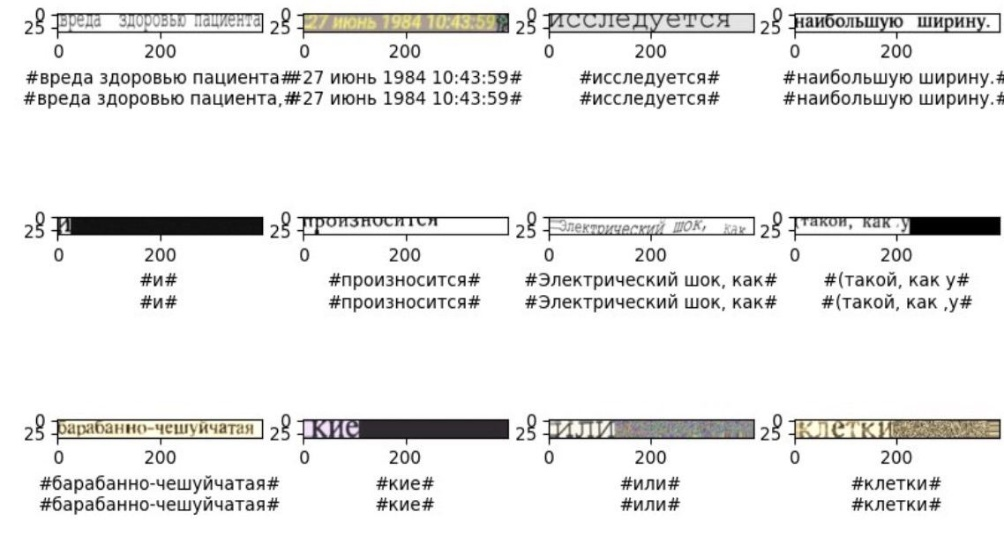 </td>
<td> 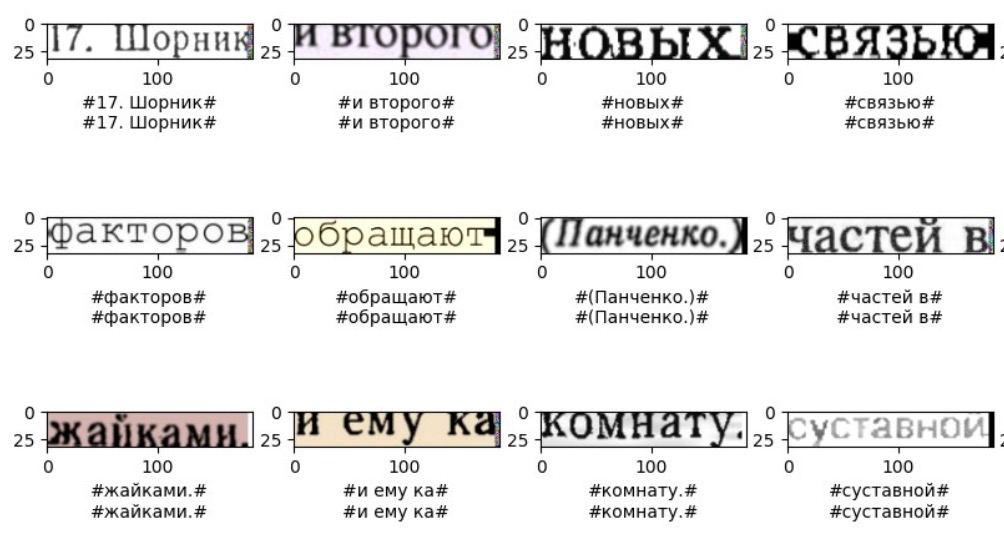 </td>
</tr></table>

Давайте посмотрим на интерфейс класса. Для начала - что передается в конструктор: 

+ `adapters` - список кортежей, каждый кортеж - это адаптер и его процент, где процент - это доля изображений в батче, которые будут браться из этого адаптера. Проценты всех адаптеров должны быть равны 1
+ `transforms` - преобразования для изображений (из `albumentations`)
+ `post_transforms` - обязательные преобразования (нормализация и приведение к тензору)
+ `tokenizer` - токенизатор типа `TokenizerForCTC`, которые вы реализовали выше; 
+ `epoch_size` - количество картинок в эпохе. По умолчанию значение равно -1 - брать все изображения из адаптеров
+ `sort_by_length` - сортировать ли батчи по длине
+ `target_height` - целевая высота, к которой будут приведены все изображения
+ `max_width` - максимальная ширина изображения после всех преобразований. Если она будет больше, то мы сожмем изображение до этого значения (чтобы обработать выбросы и слишком длинные картинки). 

Какие еще есть инетерсные методы в этом классе: 
+ `__getitem__` - возвращает данные об изображении (исходное изображение, преобразованное изображение, текст, преобразованный текст и длину текста) в том виде, который можно будет подавать в модель и функцию потерь с метркиами; 
+ `_prepare_epoch_data` - загружает изображения в количестве `epoch_size` и сортирует их по длине (если `sort_by_length=True`) 
+ `reset_epoch` - метод будет вызываться при обучении на каждой эпохе и перезагружать данные для эпохи с помощью метода `_prepare_epoch_data`. 

Советуем изучить содержание класса, он не слишком сложный, но кода много... 

### 1.5.3. DataLoader

Третий уровень абстракции над данными - `torch.utils.data.DataLoader`.

Он стандартный, поэтому не будем на нем подробно останавливаться. 

Осталось инициализировать датасеты и даталоадеры для обучения и валидации:

In [ ]:
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(augmentations)

# для валидации преобразования отключаем
val_transform = A.NoOp()

# обязательные преобразования - нормализация и приведение к тензору
post_transform = A.Compose([
    A.Normalize(
        mean=[0., 0., 0.],
        std=[1., 1., 1.],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])

In [ ]:
from utils import PadCollate
from utils import set_seed
from utils import worker_init_fn
from utils import OCRDataset

from torch.utils.data import DataLoader

train_dataset = OCRDataset(
    adapters=[(en_train_adapter, 0.3), (ru_train_adapter, 0.7)],
    transforms=train_transform,
    post_transforms=post_transform,
    tokenizer=tokenizer,
    epoch_size=-1,
    sort_by_length=True,
    target_height=32,
    max_width=1024,
)

val_dataset = OCRDataset(
    adapters=[(en_val_adapter, 0.3), (ru_val_adapter, 0.7)],
    transforms=val_transform,
    post_transforms=post_transform,
    tokenizer=tokenizer,
    epoch_size=-1,  # чтобы на валидации прогонялись все возможные данные
    sort_by_length=True,
    target_height=32,
    max_width=1024,
)

# вспомогательный класс из utils.py, который добавляет паддинг во все картинки и возвращает готовый батч
collate = PadCollate()

set_seed(17)

num_workers = 0
train_batch_size = 128
train_dl = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=True,
    drop_last=True
)
val_batch_size = 64
val_dl = DataLoader(
    val_dataset,
    batch_size=val_batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=False,
    drop_last=False
)

Данные готовы!

Теперь можно переходить к методам оценки качества моделей - метрики CAR и WAR, и лосс функции CTC Loss.

# 2. Функция потерь и метрики

## 2.1. Функция потерь CTC Loss

Настоятельно рекомендуем попробовать реализовать CTC loss самостоятельно, однако, мы не будем давать его как обязательное домашнее задание, так как оно может занять достаточно много времени и отлаживать его будет весьма сложно. Мы возьмем реализацию CTC loss из Pytorch, так как она, ко всему прочему, будет еще и гораздо более оптимизированная, чем самописная:

In [ ]:
from torch.nn import CTCLoss
from torch.nn.modules.loss import _Loss  # базовый класс для всех функций потерь

ctc_loss = CTCLoss(zero_infinity=True)  # zero_infinity=True - для стабильности вычислений

## 2.2. Метрики CAR, WAR

Получая на вход картинку, модель будет нам предсказывать тензор, который `tokenizer` будет преобразовывать в строку, и после предсказания необходимо эту строку сравнивать с истинной. 

Предположим, что истинная строка была "Распознавание текста", а предсказанная "распознавание_текстаа". 

Очевидный метод сравнения двух строчек - это расстояние Левенштейна (подробнее можно прочитать про него [здесь](https://en.wikipedia.org/wiki/Levenshtein_distance)). Напомним самое главное: данное расстояние - это количество действий, необходимых для получения из первой строки второй кратчайшим образом (действия - D (delete) — удалить, I (insert) — вставить, R (replace) — заменить).

Соответственно, для данных двух строк расстояние будет равно 3: изменить первый символ; изменить 14 символ; удалить поледний символ.

Метрика CAR (char accuracy rate) будет нам возвращать среднее (и нормализованное на максимальную длину) расстояние Левенштейна для всех пар (истинный текст, распознанный текст), вычтенное из 1. 

Метрика WAR - это на более привычном языке просто accuracy, то есть доля полностью совпавших пар (истинный текст, распознанный текст) от общего их количества.

### Задача 5. Метрики

Необходимо реализовать методы `_car` и `_war` класса `Evaluator`. Подсказки: 

+ `_car` - для каждой пары (истинный текст, распознанный текст) считаем расстояние Левенштейна, делим на максимальную длину из пары строк - так мы получим список нормализованных расстояний. Затем считаем среднее, вычитаем из 1 - вот и метрика готова! (при желании можно написать в одну строку)
+ `_war`- просто accuracy, так что подсказок не будет :) 

### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
class Evaluator(object):
    """
    Класс для подсчета метрик CAR (char accuracy rate) и WAR (word accuracy rate или просто accuracy).
    """
    def __call__(self, gt_labels: List[str], pred_labels: List[str]):
        """
        Метод для подсчета метрик CAR и WAR.

        Args:
            gt_labels: истинные тексты
            pred_labels: предсказанные моделью тексты

        Returns:
            словарь со значениями метрик CAR и WAR
        """
        result = {
            'car': self._car(gt_labels, pred_labels),
            'war': self._war(gt_labels, pred_labels),
        }
        return result

    @staticmethod
    def _car(gt_labels: List[str], pred_labels: List[str]) -> float:
        """
        Метод для подсчета метрики CAR.

        Args:
            gt_labels: истинные тексты
            pred_labels: предсказанные моделью тексты

        Returns:
            значение метрики CAR
        """
        pass

    @staticmethod
    def _war(gt_labels: List[str], pred_labels: List[str]) -> float:
        """
        Метод для подсчета метрики WAR.

        Args:
            gt_labels: истинные тексты
            pred_labels: предсказанные моделью тексты

        Returns:
            значение метрики WAR
        """
        pass

### Проверка задачи

In [ ]:
evaluator = Evaluator()
metrics = evaluator(['12'], ['22'])
assert round(metrics['car'], 3) == 0.5, 'Что-то не так с CAR. Левенштейн равен 1, длина 2, значит должно быть 0.5. '
assert round(metrics['war'], 3) == 0.0, 'Что-то не так с WAR. Строки не равны, значит должно быть 0. '

metrics = evaluator(['Распознавание текста', 'Текст два'], ['распознавание_текстаа', 'Текст два'])
assert round(metrics['car'], 3) == 0.929, 'Что-то не так с CAR...'
assert round(metrics['war'], 3) == 0.5, 'Что-то не так с WAR...'

# 3. Модель

Для нашей задачи мы будем обучать [CRNN (Convolutional Recurrent Neural Network](https://arxiv.org/abs/1507.05717)). Ее архитектура выглядит следующим образом (снизу вверх):

<img src="https://images4.russianblogs.com/922/df/df7f964dc5a09b659096b55b705c96f2.png">

Сигнал через нейронную сеть проходит в несколько этапов:

1. Через предобученный сверточный backbone (в нашем случае -- ResNext), в результате получается тензор $batch\_size \times channels \times height \times width$.
2. Тензор схлопывается по высоте, чтобы осталась только одна последовательность в тензоре (вдоль $width$). Это можно сделать различными способами, мы будем делать это при помощи `GlobalMaxPooling` (делает max pooling по одной из размерностей в единицу). В результате получится тензор размером $batch\_size \times channels \times width$.
3. Последовательность обрабатывается рекуррентной частью нейронной сети, на выходе получаем выходной сигнал.

Выходной сигнал в дальнейшем подается в CTC Loss, который завершает граф вычисления. Минимизируя лосс функцию, мы обучаем модель правильно создавать правильные сигналы, которые затем с помощью `tokenizer` преобразуются в корректный текст. 

## 3.1. Backbone: ResNext

Подготовим backbone. Для этого загрузим соответствующую сеть из `torchvision` и оставим только нужные модули.

Кроме `torchvision` есть другие полезные библиотеки с моделями: `timm` и `segmentation_models_pytorch`.

In [ ]:
import torchvision
from torch import nn

raw_cnn = torchvision.models.resnext50_32x4d(pretrained=True)
all_layers = [raw_cnn.conv1, raw_cnn.bn1, raw_cnn.relu, raw_cnn.maxpool,
              raw_cnn.layer1, raw_cnn.layer2, raw_cnn.layer3, raw_cnn.layer4]
cnn = nn.Sequential(*all_layers)

Теперь посмотрим выход этой сети, если подадим в нее картинку:

In [ ]:
long_image = cv2.imread(base_folder+'images/long_image.png')
print(long_image.shape)
plt.imshow(long_image)
plt.show()

long_image_tensor = post_transform(image=long_image)['image'].float()
shape = cnn(long_image_tensor.unsqueeze(0)).shape
print(f'Ширина выхода из сети: {shape[-1]}')
text_on_image = 'Это достаточно длинная строка'
print(f'Длина текста на изображении: {len(text_on_image)}')

Как видим, у сети есть всего 14 таймстемпов, чтобы предсказать 29 символов. Явно ей будет очень трудно! Поэтому надо что-то делать с сетью и расширять ее выход. 

Есть 2 варианта: менять сеть в начале или в конце. В начале можно добавить страйд в первом слое (это очень даже неплохо работает, например [здесь](https://arxiv.org/abs/1709.02054)), но тогда придется менять всю остальную сеть. 

Второй вариант - менять ее с конца, то есть убрать несколько слоев на конце, чтобы ширина была преемлемая. 

### Задача 6. Слои ResNext

Реализуйте ResNext с динамическим количеством слоев (подсказка - первые слои `conv1`, `bn1`, `relu` и `maxpool` лучше не трогать) и подобрать такое количество слоев так (из слоев `layer1`, `layer2`, `layer3`, `layer4`), чтобы ширина выхода была больше, чем количество символов на изображении. 

#### Код

In [ ]:
# КОД ДЛЯ СТУДЕНТА
class DynamicResNext(nn.Module):
    def __init__(self, num_layers: int):
        super().__init__()
        self.cnn = ...
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.cnn(x)
    
num_layers = ...

#### Проверка

In [ ]:
resnext = DynamicResNext(num_layers)
out_width = resnext(long_image_tensor.unsqueeze(0)).shape[-1]
assert out_width > len(text_on_image), 'Выход сети по ширине меньше, чем количество символов на изображении. '

## 3.2. Модель: Backbone + Рекуррентная часть

Мы подобрали количество слоев, теперь пришла пора собирать итоговую модель, в которой мы используем `DynamicResNext`, `GlobalMaxPool2d` и рекуррентную часть, которая у нас реализована в виде класса `BidirectionalLSTM`. В ней не только слой `torch.nn.LSTM`, но еще линейный слой поверх `LSTM`, а также пару дополнительных атрибутов, которые позволяют корректно экспортировать эту конструкцию под любое железо, будь то `cpu` или `cuda`. 

### Задача 5. Модель

Необходимо реализовать конструктор класса `ResnextCRNN`. Модель состоит из двух частей: `self.cnn` и `self.rnn`. 

- `self.cnn`: необходимо загрузить бэкбон `DynamicResNext` с нужным количеством слоев. После этого понадобится "схлопнуть" третью размерность (высоту изображения) с помощью слоя `GlobalMaxPool2d`. Эти слои можно объединить с помощью `nn.Sequential`, так как они вызываются последовательно. 
- `self.rnn`: необходимо создать `nn.Sequential` из двух слоев `BidirectionalLSTM`: у первого на входе параметры (`n_channels` (вычисляется из выходного количества каналов у `self.cnn`), `num_hidden`, `num_hidden`), у второго - (`num_hidden`, `num_hidden`, `num_classes`). 

#### Код

In [ ]:
from utils import BidirectionalLSTM
from utils import GlobalMaxPool2d

# КОД ДЛЯ СТУДЕНТА
class ResnextCRNN(nn.Module):
    def __init__(
        self,
        num_classes: int,
        num_hidden: int,
        num_layers: int
    ):
        """
        Класс, имплементирующий CRNN на бэкбоне RexNext по аналогии со статьей https://arxiv.org/abs/1507.05717.

        Args:
            num_classes: количество классов (размер алфавита)
            num_hidden: количество признаков в скрытом состоянии RNN
        """
        super().__init__()
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x1 = self.cnn(x.float())
        x = x1.squeeze(2)
        x = x.permute(2, 0, 1)
        x = self.rnn(x)
        return x


#### Проверка

In [ ]:
model = ResnextCRNN(num_hidden=256, num_classes=10, num_layers=num_layers)
assert len(model.cnn) == 2, 'model.cnn должен быть nn.Sequential из 2х частей.'
assert len(model.rnn) == 2, 'model.rnn должен быть nn.Sequential из 2х частей.'

input_tensor = torch.rand(
    32,  # размер батча
    3,   # кол-во каналов
    32,  # высота
    500  # ширина
)
output_tensor = model(input_tensor)
assert list(output_tensor.shape) == [
    63,  # кол-во фреймов
    32,  # размер батча
    10   # кол-во классов
], 'Размерность выхода из сети не совпадает с ожидаемой... Возможно не то количество классов/каналов?'

# 4. Процесс обучения

## 4.1. Lightning Module

In [ ]:
import pytorch_lightning as pl
import wandb

from torch import optim
from utils import draw_predictions

class CRNNRunner(pl.LightningModule):
    """
    Основной класс для обучения модели CRNN.
    """
    def __init__(self, tokenizer: TokenizerForCTC, loss: _Loss):
        super(CRNNRunner, self).__init__()

        self.model = ResnextCRNN(num_hidden=256, num_classes=tokenizer.n_token, num_layers=num_layers)
        self.evaluator = Evaluator()

        self.loss = loss

        self.draw_batch_idx = 0

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def training_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Метод с имплементацией шага обучения.

        Args:
            batch: батч
            batch_idx: индекс батча

        Returns:
            лосс
        """
        images, raw_images, labels, targets, lengths = batch
        current_batch_size = images.shape[0]
        preds = self.forward(images)
        preds_size = torch.IntTensor([preds.size(0)] * current_batch_size)
        preds = preds.log_softmax(dim=2)
        loss = self.loss(preds, targets, preds_size, lengths)
        self.log("train_loss", loss.detach().cpu(), on_step=True, on_epoch=False)

        _, preds = preds.max(2)
        preds = preds.transpose(1, 0).detach().cpu().numpy()
        pred_labels = [tokenizer.decode(p) for p in preds]

        log_images_every_n_epoch = 5
        if self.current_epoch % log_images_every_n_epoch == 0 and batch_idx == self.draw_batch_idx:
            with torch.no_grad():
                train_preds = draw_predictions(raw_images, labels, pred_labels)
                if isinstance(self.logger, WandbLogger):
                    trainer.logger.experiment.log({"train_preds": wandb.Image(train_preds)})

        return loss

    def training_epoch_end(self, _: Any) -> None:
        """
        Метод, который вызывается после обучения на очередной эпохе и вызывает перезагрузку данных для новой эпохи.
        """
        self.trainer.train_dataloader.dataset.datasets.reset_epoch()

    def validation_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Метод с имплементацией шага валидации.

        Args:
            batch: батч
            batch_idx: индекс батча
        """
        images, raw_images, labels, targets, lengths = batch
        current_batch_size = images.shape[0]
        preds = self.forward(images)
        preds_size = torch.IntTensor([preds.size(0)] * current_batch_size)
        preds = preds.log_softmax(dim=2)
        loss = self.loss(preds, targets, preds_size, lengths)
        self.log("val_loss", loss.detach().cpu(), on_step=False)

        _, preds = preds.max(2)
        preds = preds.transpose(1, 0).detach().cpu().numpy()
        pred_labels = [tokenizer.decode(p) for p in preds]

        metrics = self.evaluator(labels, pred_labels)

        for m_name, m_value in metrics.items():
            self.log(f"val_{m_name}", m_value, on_step=False)

        log_images_every_n_epoch = 5
        if self.current_epoch % log_images_every_n_epoch == 0 and batch_idx == self.draw_batch_idx:
            with torch.no_grad():
                val_preds = draw_predictions(raw_images, labels, pred_labels)
                if isinstance(self.logger, WandbLogger):
                    trainer.logger.experiment.log({"val_preds": wandb.Image(val_preds)})

    def validation_epoch_end(self, _: Any) -> None:
        """
        Метод, который вызывается после валидации на очередной эпохе и выбирает случайный индекс батча, изображения
        которого будут логироваться.
        """
        self.draw_batch_idx = np.random.randint(0, len(self.trainer.val_dataloaders[0]))

    def test_step(self, batch: Any, batch_idx: int) -> Any:
        """
        Метод с имплементацией шага тестирования (аналогичный шагу валидации).

        Args:
            batch: батч
            batch_idx: индекс батча
        """
        self.validation_step(batch, batch_idx)

    def configure_optimizers(self) -> Tuple[List[Any], List[Any]]:
        """
        Метод для настройки оптимизаторов обучения и планировщиков для learning rate (LR).

        Returns:
            список оптимизаторов; список планировщиков LR
        """
        optimizer = optim.AdamW(self.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=0.0001)
        lr_scheduler = torch.optim.lr_scheduler.CyclicLR(
            optimizer=optimizer,
            base_lr=0.0001,
            max_lr=0.001,
            step_size_up=2000,
            step_size_down=5000,
            mode="triangular",
            cycle_momentum=False,
        )
        scheduler = {
            "scheduler": lr_scheduler,
            "interval": "step",
            "frequency": 1,
            "monitor": "val_loss",
        }
        print(lr_scheduler)
        print(optimizer)
        return [optimizer], [scheduler]

## 4.2. Обучение

In [ ]:
import os

from datetime import datetime

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger


set_seed(18)

model = CRNNRunner(tokenizer, ctc_loss)

version = datetime.now().strftime("%Y%m%dT%H%M%S")

lr_logger = LearningRateMonitor()

logs_dir = "logs"
project_name = "sber-tr-course"
exp_name = "baseline"

cfg_save_dir = os.path.join(logs_dir, project_name, exp_name)

# колбэк для сохранения весов каждый раз, когда улучшилось качество на валидации
checkpoint_callback = ModelCheckpoint(
    dirpath=cfg_save_dir,
    filename='{epoch}_{val_war:.4f}',
    mode="max",
    monitor="val_war",
    save_top_k=1,
    verbose=True
)

In [ ]:
os.environ['WANDB_API_KEY'] = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
logger = WandbLogger(
    save_dir=logs_dir,
    project=project_name,
    name=exp_name,
)

In [ ]:
trainer = Trainer(
    callbacks=[checkpoint_callback, lr_logger],
    logger=logger,
    gpus=[0],
    accumulate_grad_batches=1,
    min_epochs=1,
    max_epochs=2,
    max_steps=2,
    gradient_clip_val=0.5,
    num_sanity_val_steps=50,
    check_val_every_n_epoch=1,
    fast_dev_run=False,
)

In [ ]:
trainer.fit(model, train_dataloaders=train_dl, val_dataloaders=val_dl)

### Проверка качества модели

In [ ]:
test_adapter = CsvAdapter(
    name='en_synth',
    images_dir='./data/en_synth/val',
    csv_fpath='./data/en_synth/val.csv',
    compute_length_by="label",  # label, image
    load_image=False
)
test_transform = A.NoOp()
test_dataset = OCRDataset(
    adapters=[(test_adapter, 1.0)],
    transforms=test_transform,
    post_transforms=post_transform,
    tokenizer=tokenizer,
    epoch_size=-1,
    sort_by_length=True,
    target_height=32,
    max_width=1024,
)

num_workers = 2
test_batch_size = 32

test_dl = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    num_workers=num_workers,
    collate_fn=collate,
    worker_init_fn=worker_init_fn,
    pin_memory=True,
    shuffle=False,
    drop_last=False
)

In [ ]:
model = CRNNRunner(tokenizer)
_ = trainer.test(model=model, dataloaders=test_dl)

# 5. Экспорт модели

### Задача 6. Экспорт модели

Экспорт происходит аналогично с экспортом модели в тетрадке по детекции - только размер входного изображения будет другой. 

In [ ]:
from typing import Type, Dict

# КОД ДЛЯ СТУДЕНТА
def jit_save(
    checkpoint_path: str, 
    jit_path: str, 
    runner_class: Type[CRNNRunner],
    runner_kwargs: Dict[str, Any]
) -> None:
    pass

### Проверка задачи 6

In [ ]:
checkpoint_path = 'ckpt.ckpt'
jit_path = f'ckpt.jit'
runner_kwargs = {'tokenizer': tokenizer}
jit_save(checkpoint_path, jit_path, CRNNRunner, runner_kwargs)

path_msg = 'Модель сохранилась по неправильному пути.'
assert os.path.exists(jit_path), path_msg
original_model = CRNNRunner.load_from_checkpoint(checkpoint_path, **runner_kwargs).model.eval()
saved_model = torch.jit.load(jit_path).eval()
type_msg = 'Модель сохранилась в непарвильном формате. Точно был вызван метод torch.jit.trace?'
assert isinstance(saved_model, torch.jit._script.RecursiveScriptModule), type_msg
inp = torch.rand(1, 3, 32, 256)
infer_msg = 'Выход из экспортированной модели не совпадает с выходом из оригинальной модели.'
with torch.no_grad():
    assert torch.allclose(original_model(inp), saved_model(inp)), infer_msg

# 6. Inference

### Задача 7. Инференс

Необходимо реализовать метод, принимающий на вход модель и изображение и возвращающий предсказанный текст. Напоминаем: для начала изображение необходимо преобразовать с помощью `post_transform`. 

In [ ]:
from typing import Union

from albumentations import BasicTransform, Compose, OneOf

# КОД ДЛЯ СТУДЕНТА
def inference(
    model: nn.Module, 
    image: np.ndarray, 
    transform: Union[BasicTransform, Compose, OneOf],
    tokenizer: TokenizerForCTC, 
    device: str = 'cpu'
) -> str:
    """
    Метод с имплементацией инференса модели.

    Args:
        model: модель
        image: изображение типа np.ndarray
        transform: преобразования для изображения

    Returns:
        предсказанный текст с изображения
    """
    pass

### Проверка задачи 7

In [ ]:
model = torch.jit.load('/content/drive/MyDrive/DeepLearning/ocr.jit')
model.eval()

image = cv2.imread(base_folder+"images/example.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

result = inference(model, image, post_transform, tokenizer)
assert isinstance(result, str), 'Метод inference должен возвращать строку.'
assert len(result) > 0, 'Метод inference вернул пустую строку. Точно модель достаточно обучена?'

In [ ]:
# визуализация предсказания
result = draw_predictions([image], predicted_texts=[result])
result.show()

# 7. Подведение итогов

В этой тетрадке мы прошли полный путь от сбора данных до инференса модели распознавания текста. Кратко, но ёмко, о том, что мы сделали и узнали: 

- Сгенерировали синтетический датасет с помощью данных из русской и английской Википедии и библиотеки `trdg`;
- Посмотрели, какие аугментации подходят для такого датасета, а также написали самостоятельно одну аугментацию;
- Реализовали класс CTC токенизатора, который кодирует текст в тензор и декодирует тензор в текст;
- Узнали, какие могут проблемы у данных для распознавания текста и как решать эти проблемы (сэмплирование по ширине, сэмплирование с дополнительными символами);
- Изучили метрики и функции потерь для OCR, а также частично реализовали эти метрики: CAR и WAR;
- Узнали про то, как выбрать правильный backbone для модели CRNN, как его кастомизировать и как объединить с рекуррентными слоями; 
- Обучили кастомную модель CRNN на только что сгенерированных данных;
- Закрепили знания о том, как необходимо экспортировать и инференсить модель в формате `TorchScript`.

Далее нас ждет третий этап обработки документов - анализ структуры текста. 

